[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_02_input_manipulation/Lab2_Evasion_Attacks.ipynb)

# **Lab 2: Evasion Attacks (Adversarial Examples)**

**Course:** Introduction to Data Security Pr.  
**Module 2:** Input Data Manipulation  
**Estimated Time:** 120 minutes

---

## **Learning Objectives**

By the end of this lab, you will be able to:
- Generate adversarial examples using FGSM and PGD
- Measure model robustness under $\ell_\infty$ perturbations
- Visualize perturbations and their impact on predictions
- Compare clean vs. adversarial accuracy
- Discuss the robustness–accuracy tradeoff

## **Table of Contents**
1. [Setup & Imports](#setup)  
2. [Load Model & Dataset](#data)  
3. [Baseline Evaluation](#baseline)  
4. [FGSM Attack](#fgsm)  
5. [PGD Attack](#pgd)  
6. [Targeted Evasion Attacks](#targeted)  
7. [Library Implementation (secml-torch)](#library)  
8. [Exercises](#exercises)

## **1. Setup & Imports** <a name="setup"></a>

In [13]:
# If needed, install dependencies
# !pip install torch torchvision matplotlib numpy
!pip install secml-torch -q

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## **2. Load Model & Dataset** <a name="data"></a>

We will reuse the MNIST model trained in Lab 1a. If you don’t have the checkpoint, train a quick baseline model in this notebook.

In [3]:
# Load MNIST test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Optional train set for fallback training
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define a simple CNN
class StandardCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = StandardCNN().to(device)

model_path = 'standard_mnist_cnn.pth'
model.eval()

# Normalized clamp bounds for MNIST
mnist_mean = 0.1307
mnist_std = 0.3081
min_val = (0.0 - mnist_mean) / mnist_std
max_val = (1.0 - mnist_mean) / mnist_std
print(f"Normalized clamp range: [{min_val:.2f}, {max_val:.2f}]")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]


Model checkpoint not found. Training a quick baseline below.
Normalized clamp range: [-0.42, 2.82]


In [4]:
print("Training a quick baseline model (2 epochs, limited batches)...")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.train()
max_batches = 100
for epoch in range(2):
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        if i >= max_batches:
            break
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/2: Loss={running_loss / max_batches:.4f}")
model.eval()
print("Baseline training complete.")

Training a quick baseline model (2 epochs, limited batches)...
Epoch 1/2: Loss=0.4897
Epoch 2/2: Loss=0.1195
Baseline training complete.


## **3. Baseline Evaluation** <a name="baseline"></a>

In [5]:
def evaluate(model, loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

clean_acc = evaluate(model, test_loader)
print(f"Clean accuracy: {clean_acc * 100:.2f}%")

Clean accuracy: 97.38%


## **4. FGSM Attack** <a name="fgsm"></a>

The Fast Gradient Sign Method (FGSM) crafts adversarial examples by taking a single step in the direction of the input gradient.

In [6]:
def fgsm_attack(model, x, y, epsilon=0.3):
    x = x.clone().detach().to(device)
    y = y.to(device)
    x.requires_grad = True

    logits = model(x)
    loss = nn.CrossEntropyLoss()(logits, y)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * x.grad.sign()
    x_adv = x + perturbation
    x_adv = torch.clamp(x_adv, min_val, max_val)
    return x_adv.detach()

## **5. PGD Attack** <a name="pgd"></a>

Projected Gradient Descent (PGD) iterates FGSM steps and projects back into the $\epsilon$-ball.

In [7]:
def pgd_attack(model, x, y, epsilon=0.3, alpha=0.01, steps=40):
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_adv = x + 0.001 * torch.randn_like(x)

    for _ in range(steps):
        x_adv.requires_grad = True
        logits = model(x_adv)
        loss = nn.CrossEntropyLoss()(logits, y)
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad.sign()

        x_adv = x_adv + alpha * grad
        perturbation = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + perturbation, min_val, max_val).detach()
    return x_adv

### **Robustness Evaluation**

In [8]:
def adversarial_accuracy(model, loader, attack_fn, **kwargs):
    correct, total = 0, 0
    model.eval()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack_fn(model, x, y, **kwargs)
        logits = model(x_adv)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

fgsm_acc = adversarial_accuracy(model, test_loader, fgsm_attack, epsilon=0.3)
pgd_acc = adversarial_accuracy(model, test_loader, pgd_attack, epsilon=0.3, alpha=0.01, steps=20)

print(f"FGSM accuracy (eps=0.3): {fgsm_acc * 100:.2f}%")
print(f"PGD accuracy (eps=0.3):  {pgd_acc * 100:.2f}%")

FGSM accuracy (eps=0.3): 86.04%
PGD accuracy (eps=0.3):  90.77%


### **Visual Analysis**

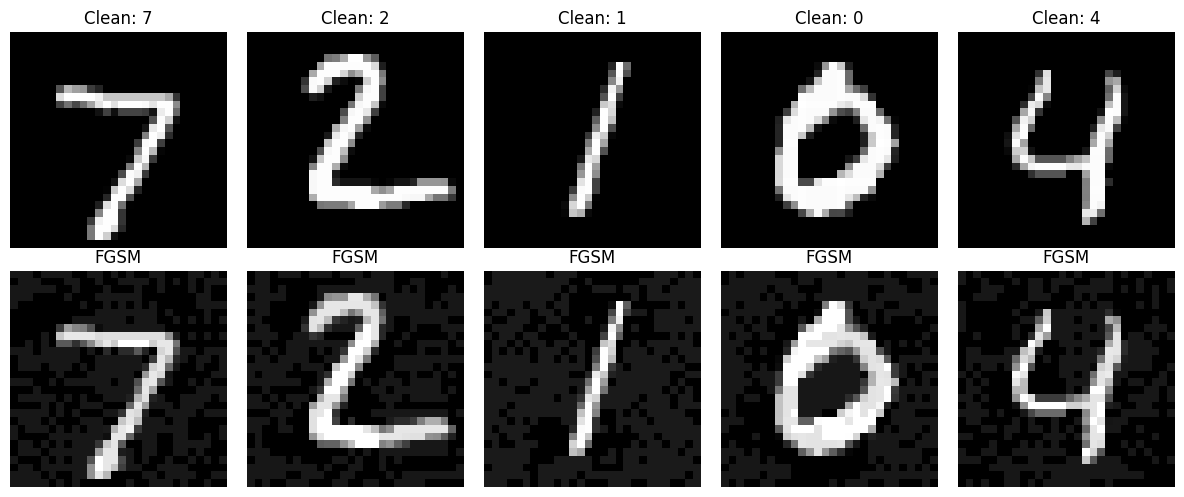

In [9]:
# Visualize adversarial examples
x, y = next(iter(test_loader))

x_adv_fgsm = fgsm_attack(model, x[:5], y[:5], epsilon=0.3)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow((x[i].squeeze() * 0.3081 + 0.1307).cpu(), cmap='gray')
    axes[0, i].set_title(f"Clean: {y[i].item()}")
    axes[0, i].axis('off')

    axes[1, i].imshow((x_adv_fgsm[i].squeeze() * 0.3081 + 0.1307).cpu(), cmap='gray')
    axes[1, i].set_title("FGSM")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## **6. Targeted Evasion Attacks** <a name="targeted"></a>

In the previous sections, we performed **untargeted** attacks, where the goal was simply to make the model misclassify the input. In a **targeted** attack, the adversary wants the model to output a *specific* incorrect class.

The optimization objective changes from maximizing the loss of the true class to minimizing the loss of a target class $y_{target}$:

$$\min_{\delta} \mathcal{L}(f(x + \delta), y_{target}) \quad \text{s.t.} \quad \|\delta\|_p \le \epsilon$$


True Label: 9
Target Label: 8
Top 3 Predictions: [9 4 8]


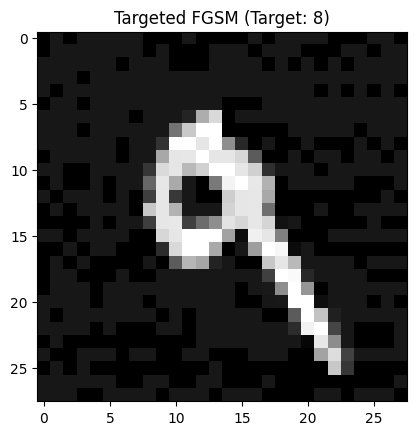

In [10]:
def targeted_fgsm_attack(model, images, target_labels, epsilon):
    images = images.clone().detach().to(device)
    target_labels = target_labels.to(device)
    images.requires_grad = True
    
    outputs = model(images)
    # We MINIMIZE the loss relative to the target label
    loss = nn.CrossEntropyLoss()(outputs, target_labels)
    
    model.zero_grad()
    loss.backward()
    
    # Gradient Descent (not Ascent) to move towards the target
    data_grad = images.grad.data
    perturbed_image = images - epsilon * data_grad.sign()
    
    # Maintain normalization bounds for MNIST
    perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
    
    return perturbed_image

# Example: Pick a '3' and try to make it look like an '8'
sample_idx = 7 # Adjust to find a '3' in your batch
x_sample, y_sample = x[sample_idx:sample_idx+1], y[sample_idx:sample_idx+1]
y_target = torch.tensor([8]).to(device)

x_adv_targeted = targeted_fgsm_attack(model, x_sample, y_target, epsilon=0.3)

# Check prediction
output_adv = model(x_adv_targeted)
pred_adv = sorted_indices = torch.argsort(output_adv, descending=True)[0]

print(f"True Label: {y_sample.item()}")
print(f"Target Label: {y_target.item()}")
print(f"Top 3 Predictions: {pred_adv[:3].cpu().numpy()}")

plt.imshow((x_adv_targeted[0].squeeze() * 0.3081 + 0.1307).cpu().detach(), cmap='gray')
plt.title(f"Targeted FGSM (Target: {y_target.item()})")
plt.show()


## **7. Library Implementation (secml-torch)** <a name="library"></a>

Now that we have implemented manual FGSM/PGD, we can replicate the same attacks using the `secml-torch` library for standardized evaluation and comparison.

Using a library like `secml-torch` simplifies research by providing standardized implementations of attacks and robust evaluation metrics.

### **7.1 Untargeted PGD with secml-torch**
We'll use the `PGD` class from `secml-torch`. Note that we must specify the `lb` (lower bound) and `ub` (upper bound) to match our normalized data range.

In [14]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.metrics.classification import Accuracy, AttackSuccessRate

# Wrap our model
secml_model = BasePytorchClassifier(model)

# Define bounds based on MNIST normalization
# Reuse min_val and max_val computed earlier from mean/std

# Instantiate PGD
# To simulate FGSM, we can use num_steps=2
pgd_attack = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    epsilon=0.3,
    num_steps=10,
    step_size=0.05,
    random_start=False,
    backend=Backends.NATIVE,
    lb=min_val,
    ub=max_val
)

# Run attack on a small batch from our test_loader
adv_loader = pgd_attack(secml_model, test_loader)

# Evaluate Robust Accuracy
acc_metric = Accuracy()
robust_acc = acc_metric(secml_model, adv_loader)
print(f"Robust Accuracy (PGD): {robust_acc.item() * 100:.2f}%")


Robust Accuracy (PGD): 81.48%



### **7.2 Targeted Attack and Attack Success Rate (ASR)**
The **Attack Success Rate (ASR)** measures the percentage of samples that the attacker successfully pushed to the target class.


In [15]:

y_target_val = 8
pgd_targeted = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    epsilon=0.3,
    num_steps=15,
    step_size=0.05,
    y_target=y_target_val,
    backend=Backends.NATIVE,
    lb=min_val,
    ub=max_val
)

adv_loader_targeted = pgd_targeted(secml_model, test_loader)

# Calculate ASR
asr_metric = AttackSuccessRate(y_target=y_target_val)
asr = asr_metric(secml_model, adv_loader_targeted)
print(f"Attack Success Rate (Target: {y_target_val}): {asr.item() * 100:.2f}%")


Attack Success Rate (Target: 8): 15.36%


## **8. Exercises** <a name="exercises"></a>

1. Run FGSM with $\epsilon \in \{0.05, 0.1, 0.2, 0.3\}$ and plot accuracy vs. $\epsilon$.  
2. Increase PGD steps to 50 and analyze how robustness changes.  
3. Compare $\ell_\infty$ vs. $\ell_2$ constraints (bonus).  
4. Discuss why PGD is generally stronger than FGSM.